# Sequence to Sequence Transformer Decoder
- Using a transformer architecture to both encode and decode a sentence, translating from english to spanish
- Data is taken from https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip

In [8]:
# imports
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os, random, shutil, pathlib, string, re

## Data Preprocessing
1. load in files and split into the two texts
2. standardize and tokenize the english and spanish texts
3. create text vectorization layers

In [9]:
# load in the pairs
text_file = pathlib.Path("spa-eng/spa-eng/spa.txt")
# text_pairs = [(english, spanish)]
text_pairs = []

with open(text_file, "rt", encoding="utf-8") as f:
    for line in f:
        english, spanish = line.split('\t')
        text_pairs.append((english, f"[start] {spanish[:-1]} [end]"))

# shuffle the data
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

random.shuffle(text_pairs)

# split the pairs into many different pairs
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples+num_val_samples]
test_pairs = text_pairs[num_train_samples+num_val_samples:]

# keep [, ]; and remove ¿
strip_chars = (string.punctuation + "¿").replace('[', '').replace(']', '')

# custom standardization; lowercase and remove strip_char characters
def custom_standardize(input_string: tf.string) -> tf.string:
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f'[{re.escape(strip_chars)}]', "")

vocab_size = 15000
sequence_length = 20

In [10]:
# create text vectorization layers; convert to integer sequence
source_vectorization = layers.TextVectorization(max_tokens=vocab_size, standardize=custom_standardize, output_mode='int', output_sequence_length=sequence_length)
target_vectorization = layers.TextVectorization(max_tokens=vocab_size, standardize=custom_standardize, output_mode='int', output_sequence_length=sequence_length + 1)

# extract the english and spanish parts, and initialize the vectorizers with their vocabulary
train_english_texts = [i[0] for i in train_pairs]
train_spanish_texts = [i[1] for i in train_pairs]

# create frequency arrays
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_spanish_texts)

batch_size = 64
@tf.function
def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return({
        "english": eng, "spanish": spa[:,:-1]
    }, spa[:,1:])

def make_dataset(pairs: list[tuple]) -> tf.data.Dataset:
    eng, spa = map(list, zip(*pairs))
    # (english sentence, spanish sentence)
    dataset = tf.data.Dataset.from_tensor_slices((eng, spa)).batch(batch_size)

    # ({'english': english tokens, 'spanish': spanish tokens except for end}, spanish tokens shifted one forward)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

# format each dataset
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

for inputs, targets in train_ds.take(1):
    print(f"English Shape: {inputs['english'].shape}")
    print(f"Spanish Shape: {inputs['spanish'].shape}")
    print(f"Target Shape: {targets.shape}")

English Shape: (64, 20)
Spanish Shape: (64, 20)
Target Shape: (64, 20)


## Transformer definitions
- Create a transformer encoder
- Create a transformer decoder

In [15]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(attention_output + inputs)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)

    def get_config(self):
        super().get_config().update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        })

In [20]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)

        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention1 = layers.MultiHeadAttention(num_heads, embed_dim)
        self.layernorm1 = layers.LayerNormalization()
        self.attention2 = layers.MultiHeadAttention(num_heads, embed_dim)
        self.layernorm2 = layers.LayerNormalization()
        self.denseproj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim)])
        self.layernorm3 = layers.LayerNormalization()

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        # creates a triangular matrix; i >= j is [[1, 0, ...], [1, 1, 0, ...], ...]
        mask = tf.cast(i >= j, dtype="int32")

        # (1, length, length) mask
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))

        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0)

        # (batch_size, length, length) mask
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        padding_mask = None
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
        attention_output_1 = self.layernorm1(inputs + attention_output_1)
        attention_output_2 = self.attention2(query=attention_output_1, value=encoder_outputs, key=encoder_outputs, attention_mask=padding_mask)
        attention_output_2 = self.layernorm2(attention_output_1 + attention_output_2)
        proj_output = self.denseproj(attention_output_2)
        return self.layernorm3(proj_output + attention_output_2)

    def get_config(self):
        super().get_config().update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads
        })

In [21]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, embed_dim, **kwargs):
        super().__init__(**kwargs)

        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.embed_dim = embed_dim

        self.word_embedding = layers.Embedding(input_dim, embed_dim)
        self.position_embedding = layers.Embedding(sequence_length, embed_dim)
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def call(self, inputs, *args, **kwargs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[-1], delta=1)
        return self.word_embedding(inputs) + self.position_embedding(positions)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "embed_dim": self.embed_dim
        })
        return config

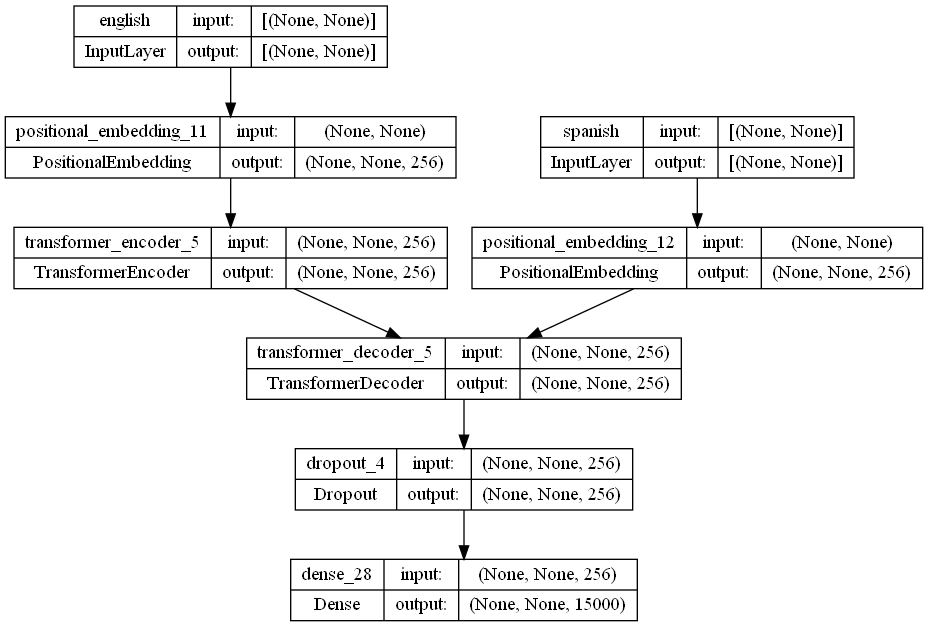

In [29]:
max_sequence_length = 20
embedding_dim = 256

english_input = keras.Input((None,), dtype="int64", name="english")
x = PositionalEmbedding(max_sequence_length, vocab_size, embedding_dim)(english_input)
encoded_output = TransformerEncoder(embedding_dim, 1024, 4)(x)

spanish_input = keras.Input((None,), dtype="int64", name="spanish")
x = PositionalEmbedding(max_sequence_length, vocab_size, embedding_dim)(spanish_input)
x = TransformerDecoder(embedding_dim, 1024, 4)(x, encoded_output)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

transformer = keras.Model([english_input, spanish_input], decoder_outputs)
transformer.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

keras.utils.plot_model(transformer, show_shapes=True)

In [30]:
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
   7/1302 [..............................] - ETA: 9:10 - loss: 6.5287 - accuracy: 0.5319

KeyboardInterrupt: 

In [ ]:
spa_vocab = target_vectorization.get_vocabulary()
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(input_sentence):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer({"english": tokenized_input_sentence, "spanish": tokenized_target_sentence})
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_vocab[sampled_token_index]
        decoded_sentence = f"{decoded_sentence} {sampled_token}"
        if sampled_token == "[end]":
            break
    return decoded_sentence

for _ in range(20):
    english_sentence, spanish_sentence = random.choice(test_pairs)
    print("-")
    print(english_sentence)
    print(decode_sequence(english_sentence))
    print(spanish_sentence)